[高速フーリエ変換の実装を難しそうかなと思っている方が、なんだ簡単じゃないですか！！ となるための実装講座です](https://caddi.tech/archives/836) という記事が分かりやすかったのでHaskellでも実装してみました

## 離散フーリエ変換
まずは普通のフーリエ変換を実装します

In [1]:
import Data.Complex

fourierTransform :: RealFloat a => [Complex a] -> [Complex a]
fourierTransform xs =
  let n = length xs
      f aj i j = aj * cis (2 * pi * fromIntegral (i * j) / fromIntegral n)
   in flip map [0..n-1] $ \i -> foldr (\(j, aj) -> (+) (f aj i j)) 0 (zip [0..] xs)

inverseFourierTransform :: RealFloat a => [Complex a] -> [Complex a]
inverseFourierTransform xs =
  let n = length xs
      f aj i j = aj * cis (-2 * pi * fromIntegral (i * j) / fromIntegral n)
   in flip map [0..n-1] $ \i -> foldr (\(j, aj) -> (+) (f aj i j)) 0 (zip [0..] xs) / fromIntegral n

元に戻ることを確認。これは気が向いたらQuickCheckで書き直したい

In [2]:
inverseFourierTransform $ fourierTransform [1, 2, 3, 4]

[1.0000000000000002 :+ 5.551115123125783e-16,2.0 :+ 3.885780586188048e-16,3.0 :+ 5.551115123125783e-17,4.0 :+ (-3.3306690738754696e-16)]

## 高速フーリエ変換
高速フーリエ変換はフーリエ変換の計算を分割して再帰的に計算するので関数型プログラミングと相性が良さそうかなと思ったけど実装は泥臭い感じになりました。うまいやり方とかあったらTwitterでこっそり教えて下さい

あと単純な実装なので2の累乗の長さのリストでしかうまく行かないやつです。

In [3]:
import Control.Arrow

splitEvenOdd :: [a] -> ([a], [a])
splitEvenOdd = (reverse *** reverse) . go ([], [])
  where go x [] = x
        go (xs, ys) [x] = (x:xs, ys)
        go (xs, ys) (x:y:zs) = go (x:xs, y:ys) zs

mapTuple2 :: (a -> b) -> (a, a) -> (b, b)
mapTuple2 f (a1, a2) = (f a1, f a2)

fastFourierTransform :: RealFloat a => [Complex a] -> [Complex a]
fastFourierTransform []  = error "The length of list must be the power of 2."
fastFourierTransform [x] = [x]
fastFourierTransform xs  =
  let n = length xs
      (bs, cs) = mapTuple2 fastFourierTransform $ splitEvenOdd xs
      atN2 xs i = xs !! (i `mod` (n `div` 2))
      f i = bs `atN2` i + cs `atN2` i * cis (2 * pi * fromIntegral i / fromIntegral n)
   in map f [0..n-1]

inverseFastFourierTransform :: RealFloat a => [Complex a] -> [Complex a]
inverseFastFourierTransform xs = map (/ fromIntegral (length xs)) $ ifft xs
  where
    ifft []  = error "The length of list must be the power of 2."
    ifft [x] = [x]
    ifft xs  =
      let n = length xs
          (bs, cs) = mapTuple2 ifft $ splitEvenOdd xs
          atN2 xs i = xs !! (i `mod` (n `div` 2))
          f i = bs `atN2` i + cs `atN2` i * cis (-2 * pi * fromIntegral i / fromIntegral n)
       in map f [0..n-1]

これも元に戻ることを確認

In [4]:
inverseFastFourierTransform $ fastFourierTransform [1,2,3,4]

[1.0 :+ 4.057416247971343e-16,2.0 :+ 9.385873628418619e-17,3.0 :+ 8.411709486180696e-17,4.0 :+ (-2.1632341619892149e-16)]

## 実験：ローパスフィルタ
実装したFFTでうまく周波数の空間に変換できてるのか確認します。低周波と高周波を合成した信号を作成し、低周波成分だけ取り出してみます。

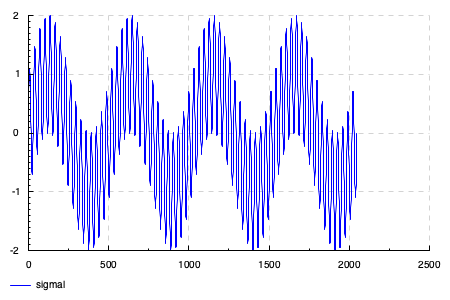

In [5]:
import Graphics.Rendering.Chart.Easy

signal :: [Double]
signal = map (\i -> sin (2 * pi * fromIntegral i / 32) + sin (2 * pi * fromIntegral i / 512)) [1..2048]

toRenderable $ plot (line "sigmal" [zip [0..] signal])

実行した高速フーリエ変換で変換して周波数空間での様子を確認

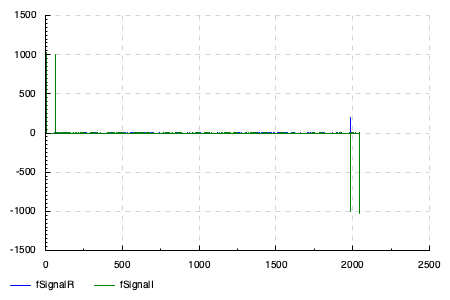

In [6]:
fSignal :: [Complex Double]
fSignal = fastFourierTransform $ map (:+ 0) signal

fSignalR, fSignalI :: [Double]
fSignalR = map realPart fSignal
fSignalI = map imagPart fSignal

toRenderable $ do
    plot (line "fSignalR" [zip [0..] fSignalR])
    plot (line "fSignalI" [zip [0..] fSignalI])

ローパスフィルタは、フーリエ変換して先頭からN個の成分以外を0にして逆フーリエ変換するように実装する

想定通りに低周波成分だけ取り出すことができた。なんだ簡単じゃないですか！！

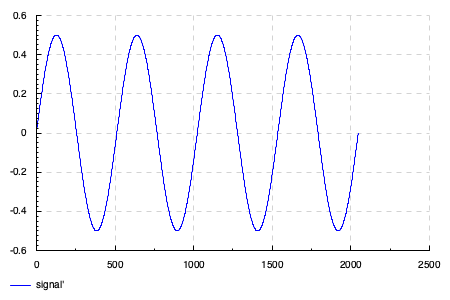

In [7]:
consider :: Num a => Int -> [a] -> [a]
consider _ []     = []
consider 0 xs     = replicate (length xs) 0
consider n (x:xs) = x : consider (n-1) xs

lowPassFilter :: Int -> [Double] -> [Double]
lowPassFilter n = map realPart . inverseFastFourierTransform . consider n . fastFourierTransform . map (:+ 0)

signal' :: [Double]
signal' = lowPassFilter 10 signal

toRenderable $ plot (line "signal'" [zip [0..] signal'])

高速フーリエ変換、完全に理解した。